# Dependency Installations


In [3]:
!pip install -q tensorflow tensorflow-datasets matplotlib tensorflow-model-optimization tf-keras

# Import Statements


In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow_model_optimization.python.core.keras.compat import keras
import tensorflow_model_optimization as tfmot
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import os
import zipfile

# Helper Methods


## Image Preprocessing Method


In [5]:
# Resizing for ResNet50 model and custom student model
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.resnet.preprocess_input(image)
    return image, label

## Label Counting Function


In [6]:
def count_labels(dataset):
    label_counter = Counter()
    for _, label in dataset:
        label_counter[label.numpy()] += 1
    return label_counter

## Image Visualization Function


In [7]:
def visualize_dataset(ds, num_images=9):
    plt.figure(figsize=(10, 10))
    for images, labels in ds.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow((images[i].numpy() + 1) / 2)
            plt.title(ds_info.features['label'].int2str(labels[i]))
            plt.axis('off')
    plt.show()

## Training Accuracy and Loss Metric Visualizing Function


In [8]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'r*-', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'r*-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

## Method to create a Conv block


In [9]:
def conv_block(x, filters, stride):
    x = keras.layers.DepthwiseConv2D(kernel_size=3, strides=stride, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU(6.)(x)

    x = keras.layers.Conv2D(filters, kernel_size=1, strides=1, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU(6.)(x)

    return x

## Method to Create Custom Model


In [11]:
def build_custom_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape)

    x = keras.layers.Conv2D(16, kernel_size=3, strides=2, padding='same')(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU(6.)(x)

    x = conv_block(x, filters=32, stride=1)
    x = conv_block(x, filters=64, stride=2) 
    x = conv_block(x, filters=128, stride=1)

    x = keras.layers.GlobalAveragePooling2D()(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

    model = keras.models.Model(inputs=inputs, outputs=outputs)
    return model

## Distillation Loss Function


In [12]:
def distillation_loss_with_kl(y_true, y_pred, teacher_logits, temperature=3.0, alpha=0.5):
    teacher_soft = tf.nn.softmax(teacher_logits / temperature)
    student_soft = tf.nn.softmax(y_pred / temperature)

    hard_loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred))

    kl_loss = tf.reduce_mean(tf.keras.losses.KLDivergence()(teacher_soft, student_soft))

    loss = alpha * kl_loss + (1 - alpha) * hard_loss
    return loss

## Distillation Training Function


In [13]:
@tf.function
def train_step(images, labels, teacher_model, student_model, optimizer):
    with tf.GradientTape() as tape:
        # Student Logits
        student_logits = student_model(images, training=True)

        # Teacher Logits
        teacher_logits = teacher_model(images, training=False)

        loss = distillation_loss_with_kl(labels, student_logits, teacher_logits)

    gradients = tape.gradient(loss, student_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, student_model.trainable_variables))

    accuracy = tf.reduce_mean(tf.keras.metrics.sparse_categorical_accuracy(labels, student_logits))
    return loss, accuracy

In [14]:
def get_gzipped_model_size(file):
  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


# Dataset


## Loading Data from Tensorflow-Datasets


In [15]:
(ds_train, ds_validation, ds_test), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    as_supervised=True,
    with_info=True
)

## Preprocessing Data


In [16]:
ds_train = ds_train.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
ds_validation = ds_validation.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

## Visualizing Train Data


2024-05-05 05:12:52.351748: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-05 05:12:52.407454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


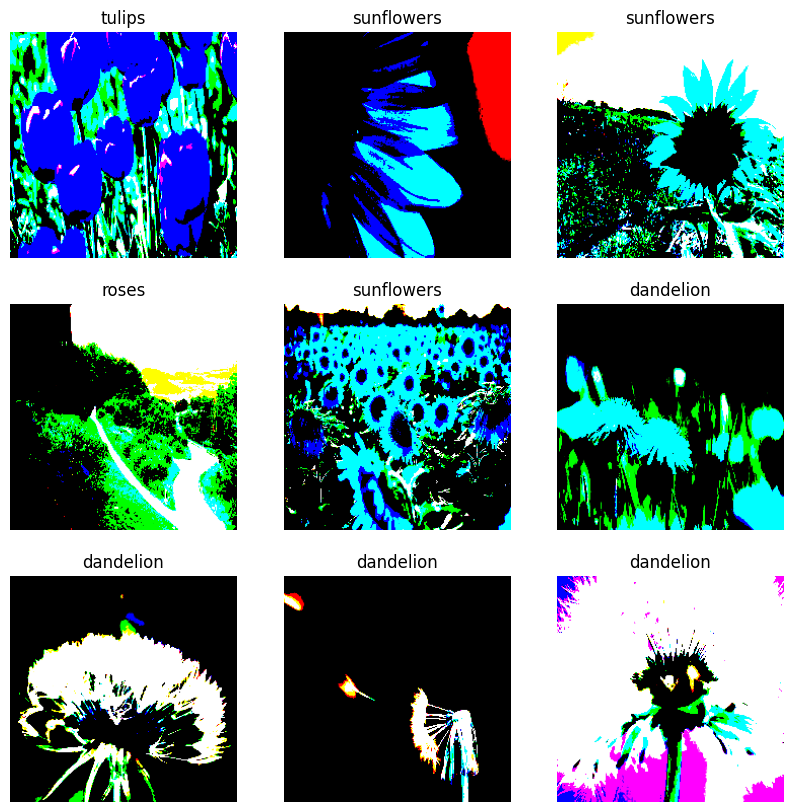

In [17]:
visualize_dataset(ds_train)

# Baseline Teacher Model - ResNet50


## Teacher Model Definition


In [18]:
base_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

teacher_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

## Compiling Teacher Model


In [19]:
teacher_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

## Training Teacher Model - With Save Checkpoint Callback


In [20]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'models/teacher_model.keras',
    monitor='val_loss',
    verbose=0,
    save_best_only=True
)

teacher_history = teacher_model.fit(
    ds_train,
    validation_data=ds_validation,
    epochs=10,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 74s 759ms/step - accuracy: 0.5574 - loss: 1.1820 - val_accuracy: 0.8501 - val_loss: 0.4197
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 64s 699ms/step - accuracy: 0.9012 - loss: 0.3202 - val_accuracy: 0.8692 - val_loss: 0.3430
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 64s 695ms/step - accuracy: 0.9354 - loss: 0.2148 - val_accuracy: 0.8828 - val_loss: 0.3158
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 68s 739ms/step - accuracy: 0.9557 - loss: 0.1586 - val_accuracy: 0.8883 - val_loss: 0.3021
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 63s 686ms/step - accuracy: 0.9749 - loss: 0.1226 - val_accuracy: 0.8937 - val_loss: 0.2930
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 63s 685ms/step - accuracy: 0.9868 - loss: 0.0977 - val_accuracy: 0.8937 - val_loss: 0.2863
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 65s 705ms/step - accuracy: 0.9887 - loss: 0.0794 - val_accuracy: 0.8937 - val_loss: 0.2813
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 64s 697ms/step - accuracy: 0.9930 - loss: 0.0656 - val_accu

## Evaluate on Test Dataset


In [21]:
teacher_model.evaluate(ds_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 597ms/step - accuracy: 0.9217 - loss: 0.2156


[0.20061607658863068, 0.9264305233955383]

## Displaying Training Metrics


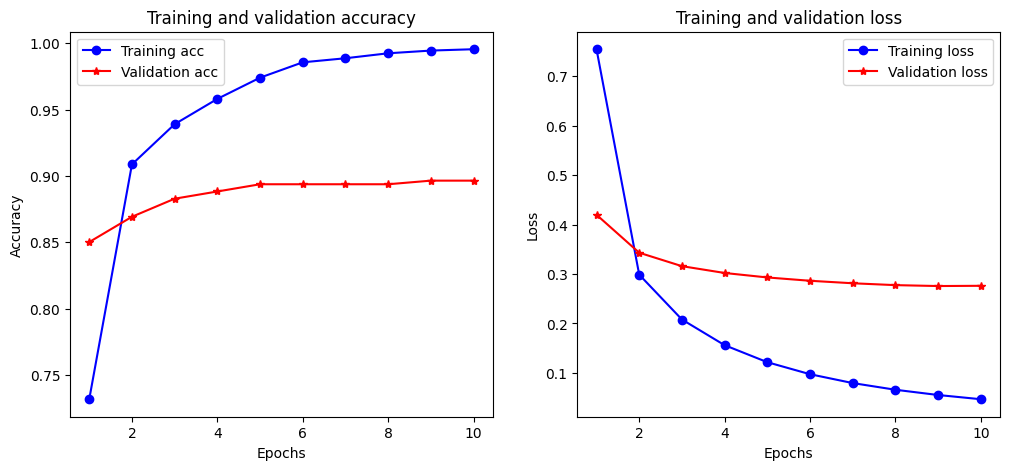

In [22]:
plot_training_history(teacher_history)

# Student Model


In [23]:
student_model = build_custom_model(input_shape=(224, 224, 3), num_classes=5)
student_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 112, 112, 16)      64        
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 112, 112, 16)      0         
                                                                 
 depthwise_conv2d (Depthwis  (None, 112, 112, 16)      160       
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 16)      64    

# Student Training - Without Knowledge Distillation


## Cloning Student Model


In [24]:
cloned_student_model = keras.models.clone_model(student_model)
cloned_student_model.set_weights(student_model.get_weights())

cloned_student_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

## Training Cloned Student Model


In [25]:
cloned_model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    'models/cloned_student_model.keras',
    monitor='val_loss',
    verbose=0,
    save_best_only=True
)

cloned_student_history = cloned_student_model.fit(
    ds_train,
    validation_data=ds_validation,
    epochs=30,
    callbacks=[cloned_model_checkpoint_callback]
)

Epoch 1/30


92/92 [==============================] - 25s 171ms/step - loss: 1.6240 - accuracy: 0.2163 - val_loss: 1.6615 - val_accuracy: 0.2425
Epoch 2/30
92/92 [==============================] - 15s 165ms/step - loss: 1.3629 - accuracy: 0.4418 - val_loss: 1.7739 - val_accuracy: 0.2425
Epoch 3/30
92/92 [==============================] - 15s 165ms/step - loss: 1.2532 - accuracy: 0.4911 - val_loss: 1.8395 - val_accuracy: 0.2425
Epoch 4/30
92/92 [==============================] - 15s 168ms/step - loss: 1.1992 - accuracy: 0.5194 - val_loss: 1.6541 - val_accuracy: 0.2725
Epoch 5/30
92/92 [==============================] - 16s 179ms/step - loss: 1.1632 - accuracy: 0.5381 - val_loss: 1.3541 - val_accuracy: 0.3896
Epoch 6/30
92/92 [==============================] - 16s 168ms/step - loss: 1.1351 - accuracy: 0.5497 - val_loss: 1.1626 - val_accuracy: 0.5395
Epoch 7/30
92/92 [==============================] - 16s 169ms/step - loss: 1.1112 - accuracy: 0.5630 - val_loss: 1.0904 - val_accuracy: 0.6022
Epoch 8/30

## Evaluating Cloned Student Model on Test Dataset


In [26]:
cloned_student_model.evaluate(ds_test)

12/12 [==============================] - 1s 40ms/step - loss: 0.8426 - accuracy: 0.6812


[0.8426492810249329, 0.6811988949775696]

## Displaying Training Loss and Accuracy Metrics


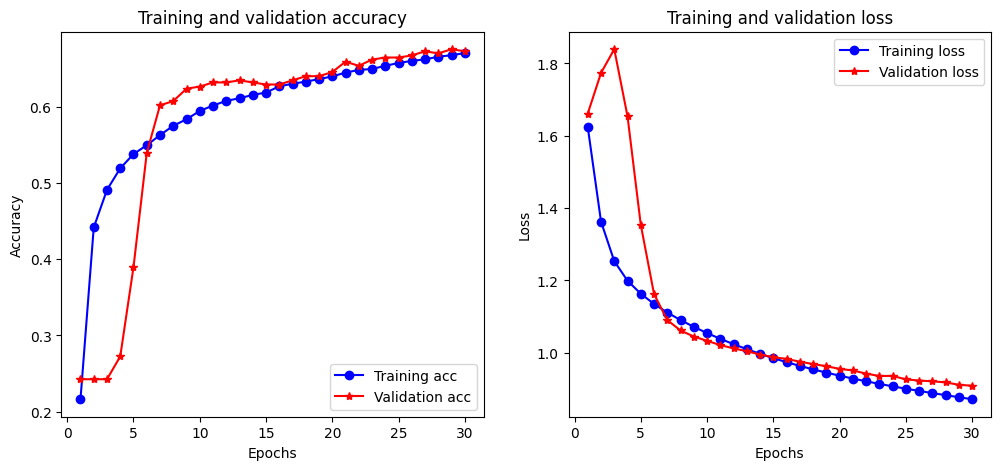

In [27]:
plot_training_history(cloned_student_history)

# Student - Knowledge Distillation


## Training With Distillation


In [28]:
optimizer = keras.optimizers.Adam()

student_model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

for epoch in range(30):
    for images, labels in ds_train:
        loss, accuracy = train_step(images, labels, teacher_model, student_model, optimizer)
        print(f"Epoch {epoch+1}, Loss: {loss.numpy()}, Accuracy: {accuracy.numpy()}")
    student_model.evaluate(ds_validation)

Epoch 1, Loss: 1.024646520614624, Accuracy: 0.09375
Epoch 1, Loss: 0.8690168857574463, Accuracy: 0.1875
Epoch 1, Loss: 0.8604925870895386, Accuracy: 0.25
Epoch 1, Loss: 0.7987650036811829, Accuracy: 0.1875
Epoch 1, Loss: 0.855283260345459, Accuracy: 0.125
Epoch 1, Loss: 0.854914128780365, Accuracy: 0.0625
Epoch 1, Loss: 0.6955879330635071, Accuracy: 0.4375
Epoch 1, Loss: 0.739283561706543, Accuracy: 0.28125
Epoch 1, Loss: 0.7358559370040894, Accuracy: 0.21875
Epoch 1, Loss: 0.7421603202819824, Accuracy: 0.3125
Epoch 1, Loss: 0.730446457862854, Accuracy: 0.28125
Epoch 1, Loss: 0.732571005821228, Accuracy: 0.375
Epoch 1, Loss: 0.6410750150680542, Accuracy: 0.6875
Epoch 1, Loss: 0.7300629615783691, Accuracy: 0.34375
Epoch 1, Loss: 0.6707764863967896, Accuracy: 0.53125
Epoch 1, Loss: 0.6614928841590881, Accuracy: 0.4375
Epoch 1, Loss: 0.6845016479492188, Accuracy: 0.4375
Epoch 1, Loss: 0.6169411540031433, Accuracy: 0.71875
Epoch 1, Loss: 0.6921178698539734, Accuracy: 0.3125
Epoch 1, Loss: 

2024-05-05 05:33:23.658871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 [==============================] - 1s 42ms/step - loss: 1.7223 - accuracy: 0.2425
Epoch 2, Loss: 0.5719746351242065, Accuracy: 0.46875
Epoch 2, Loss: 0.5294126868247986, Accuracy: 0.59375
Epoch 2, Loss: 0.5669530034065247, Accuracy: 0.5625
Epoch 2, Loss: 0.5868734121322632, Accuracy: 0.53125
Epoch 2, Loss: 0.5600423216819763, Accuracy: 0.625
Epoch 2, Loss: 0.47881051898002625, Accuracy: 0.65625
Epoch 2, Loss: 0.6906052827835083, Accuracy: 0.4375
Epoch 2, Loss: 0.5211743116378784, Accuracy: 0.5625
Epoch 2, Loss: 0.464674174785614, Accuracy: 0.6875
Epoch 2, Loss: 0.5606206059455872, Accuracy: 0.53125
Epoch 2, Loss: 0.5378339886665344, Accuracy: 0.53125
Epoch 2, Loss: 0.5692062973976135, Accuracy: 0.625
Epoch 2, Loss: 0.4745003283023834, Accuracy: 0.6875
Epoch 2, Loss: 0.48688533902168274, Accuracy: 0.6875
Epoch 2, Loss: 0.5358936786651611, Accuracy: 0.59375
Epoch 2, Loss: 0.5529584288597107, Accuracy: 0.65625
Epoch 2, Loss: 0.5345175862312317, Accuracy: 0.59375
Epoch 2, Loss: 0.468

2024-05-05 05:34:38.183804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 [==============================] - 1s 40ms/step - loss: 2.0325 - accuracy: 0.2425
Epoch 3, Loss: 0.5166398286819458, Accuracy: 0.53125
Epoch 3, Loss: 0.495411217212677, Accuracy: 0.625
Epoch 3, Loss: 0.47523343563079834, Accuracy: 0.65625
Epoch 3, Loss: 0.5513951182365417, Accuracy: 0.5625
Epoch 3, Loss: 0.5031454563140869, Accuracy: 0.65625
Epoch 3, Loss: 0.42556077241897583, Accuracy: 0.75
Epoch 3, Loss: 0.6848505139350891, Accuracy: 0.4375
Epoch 3, Loss: 0.46297985315322876, Accuracy: 0.59375
Epoch 3, Loss: 0.42446091771125793, Accuracy: 0.625
Epoch 3, Loss: 0.5139471888542175, Accuracy: 0.5625
Epoch 3, Loss: 0.4822236895561218, Accuracy: 0.6875
Epoch 3, Loss: 0.5190399885177612, Accuracy: 0.625
Epoch 3, Loss: 0.43706902861595154, Accuracy: 0.75
Epoch 3, Loss: 0.42111170291900635, Accuracy: 0.71875
Epoch 3, Loss: 0.4948039948940277, Accuracy: 0.5625
Epoch 3, Loss: 0.49954384565353394, Accuracy: 0.625
Epoch 3, Loss: 0.501918375492096, Accuracy: 0.59375
Epoch 3, Loss: 0.41902771

2024-05-05 05:35:50.351764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 [==============================] - 1s 41ms/step - loss: 2.0413 - accuracy: 0.2507
Epoch 4, Loss: 0.5003374814987183, Accuracy: 0.59375
Epoch 4, Loss: 0.4793287515640259, Accuracy: 0.6875
Epoch 4, Loss: 0.42235827445983887, Accuracy: 0.75
Epoch 4, Loss: 0.5312284827232361, Accuracy: 0.5625
Epoch 4, Loss: 0.4890522062778473, Accuracy: 0.65625
Epoch 4, Loss: 0.3938252329826355, Accuracy: 0.71875
Epoch 4, Loss: 0.6881880760192871, Accuracy: 0.53125
Epoch 4, Loss: 0.44064846634864807, Accuracy: 0.59375
Epoch 4, Loss: 0.3977777361869812, Accuracy: 0.625
Epoch 4, Loss: 0.48563581705093384, Accuracy: 0.625
Epoch 4, Loss: 0.44245588779449463, Accuracy: 0.71875
Epoch 4, Loss: 0.5004945993423462, Accuracy: 0.65625
Epoch 4, Loss: 0.4188675284385681, Accuracy: 0.75
Epoch 4, Loss: 0.39938652515411377, Accuracy: 0.75
Epoch 4, Loss: 0.4603741466999054, Accuracy: 0.625
Epoch 4, Loss: 0.46836110949516296, Accuracy: 0.59375
Epoch 4, Loss: 0.4819188714027405, Accuracy: 0.625
Epoch 4, Loss: 0.3926123

2024-05-05 05:37:01.727910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 [==============================] - 1s 42ms/step - loss: 1.6698 - accuracy: 0.3188
Epoch 5, Loss: 0.4777611494064331, Accuracy: 0.65625
Epoch 5, Loss: 0.49073171615600586, Accuracy: 0.71875
Epoch 5, Loss: 0.3922397792339325, Accuracy: 0.75
Epoch 5, Loss: 0.5122714638710022, Accuracy: 0.5625
Epoch 5, Loss: 0.44276440143585205, Accuracy: 0.71875
Epoch 5, Loss: 0.35815608501434326, Accuracy: 0.75
Epoch 5, Loss: 0.6637153029441833, Accuracy: 0.53125
Epoch 5, Loss: 0.4297816753387451, Accuracy: 0.59375
Epoch 5, Loss: 0.3714990019798279, Accuracy: 0.75
Epoch 5, Loss: 0.48025786876678467, Accuracy: 0.625
Epoch 5, Loss: 0.40896469354629517, Accuracy: 0.6875
Epoch 5, Loss: 0.4821924567222595, Accuracy: 0.625
Epoch 5, Loss: 0.3856676518917084, Accuracy: 0.75
Epoch 5, Loss: 0.37249743938446045, Accuracy: 0.78125
Epoch 5, Loss: 0.4214174747467041, Accuracy: 0.5625
Epoch 5, Loss: 0.4466567933559418, Accuracy: 0.625
Epoch 5, Loss: 0.45518115162849426, Accuracy: 0.625
Epoch 5, Loss: 0.3662332594

2024-05-05 05:38:12.675898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 [==============================] - 1s 40ms/step - loss: 1.1975 - accuracy: 0.4986
Epoch 6, Loss: 0.4704403579235077, Accuracy: 0.71875
Epoch 6, Loss: 0.4806048572063446, Accuracy: 0.71875
Epoch 6, Loss: 0.3853083550930023, Accuracy: 0.75
Epoch 6, Loss: 0.48887568712234497, Accuracy: 0.59375
Epoch 6, Loss: 0.4238895773887634, Accuracy: 0.71875
Epoch 6, Loss: 0.3599119782447815, Accuracy: 0.75
Epoch 6, Loss: 0.6427140831947327, Accuracy: 0.53125
Epoch 6, Loss: 0.41042840480804443, Accuracy: 0.625
Epoch 6, Loss: 0.34664976596832275, Accuracy: 0.78125
Epoch 6, Loss: 0.47319096326828003, Accuracy: 0.59375
Epoch 6, Loss: 0.3873259425163269, Accuracy: 0.71875
Epoch 6, Loss: 0.44789257645606995, Accuracy: 0.65625
Epoch 6, Loss: 0.34740689396858215, Accuracy: 0.78125
Epoch 6, Loss: 0.33873677253723145, Accuracy: 0.78125
Epoch 6, Loss: 0.39700520038604736, Accuracy: 0.625
Epoch 6, Loss: 0.42615237832069397, Accuracy: 0.6875
Epoch 6, Loss: 0.4113866090774536, Accuracy: 0.625
Epoch 6, Loss: 

2024-05-05 05:39:26.147940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 [==============================] - 1s 41ms/step - loss: 0.9607 - accuracy: 0.6376
Epoch 7, Loss: 0.4431351125240326, Accuracy: 0.71875
Epoch 7, Loss: 0.46955281496047974, Accuracy: 0.71875
Epoch 7, Loss: 0.3817068338394165, Accuracy: 0.75
Epoch 7, Loss: 0.47756531834602356, Accuracy: 0.59375
Epoch 7, Loss: 0.3827531337738037, Accuracy: 0.71875
Epoch 7, Loss: 0.3276664912700653, Accuracy: 0.78125
Epoch 7, Loss: 0.61814284324646, Accuracy: 0.59375
Epoch 7, Loss: 0.3940596878528595, Accuracy: 0.65625
Epoch 7, Loss: 0.32795295119285583, Accuracy: 0.78125
Epoch 7, Loss: 0.4374888837337494, Accuracy: 0.65625
Epoch 7, Loss: 0.3736913800239563, Accuracy: 0.71875
Epoch 7, Loss: 0.4419482350349426, Accuracy: 0.6875
Epoch 7, Loss: 0.32757464051246643, Accuracy: 0.8125
Epoch 7, Loss: 0.3160018026828766, Accuracy: 0.8125
Epoch 7, Loss: 0.38042643666267395, Accuracy: 0.65625
Epoch 7, Loss: 0.4118403196334839, Accuracy: 0.71875
Epoch 7, Loss: 0.39216700196266174, Accuracy: 0.6875
Epoch 7, Loss:

2024-05-05 05:40:41.121005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 [==============================] - 1s 42ms/step - loss: 0.8813 - accuracy: 0.6730
Epoch 8, Loss: 0.4223456382751465, Accuracy: 0.71875
Epoch 8, Loss: 0.4457181990146637, Accuracy: 0.75
Epoch 8, Loss: 0.366283655166626, Accuracy: 0.75
Epoch 8, Loss: 0.45932748913764954, Accuracy: 0.59375
Epoch 8, Loss: 0.36214447021484375, Accuracy: 0.75
Epoch 8, Loss: 0.3175206780433655, Accuracy: 0.78125
Epoch 8, Loss: 0.6178097128868103, Accuracy: 0.59375
Epoch 8, Loss: 0.3840939402580261, Accuracy: 0.65625
Epoch 8, Loss: 0.32937347888946533, Accuracy: 0.78125
Epoch 8, Loss: 0.4298515021800995, Accuracy: 0.65625
Epoch 8, Loss: 0.3603955805301666, Accuracy: 0.71875
Epoch 8, Loss: 0.44765180349349976, Accuracy: 0.6875
Epoch 8, Loss: 0.30097371339797974, Accuracy: 0.84375
Epoch 8, Loss: 0.3129979968070984, Accuracy: 0.875
Epoch 8, Loss: 0.3666364550590515, Accuracy: 0.6875
Epoch 8, Loss: 0.41827934980392456, Accuracy: 0.71875
Epoch 8, Loss: 0.38210949301719666, Accuracy: 0.71875
Epoch 8, Loss: 0.3

2024-05-05 05:41:53.175196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 [==============================] - 1s 42ms/step - loss: 0.8020 - accuracy: 0.7084
Epoch 9, Loss: 0.4149833917617798, Accuracy: 0.71875
Epoch 9, Loss: 0.4340890049934387, Accuracy: 0.75
Epoch 9, Loss: 0.3559873104095459, Accuracy: 0.75
Epoch 9, Loss: 0.444193959236145, Accuracy: 0.625
Epoch 9, Loss: 0.36540722846984863, Accuracy: 0.75
Epoch 9, Loss: 0.3187343180179596, Accuracy: 0.75
Epoch 9, Loss: 0.5968253016471863, Accuracy: 0.59375
Epoch 9, Loss: 0.37346574664115906, Accuracy: 0.6875
Epoch 9, Loss: 0.32256147265434265, Accuracy: 0.78125
Epoch 9, Loss: 0.4010361135005951, Accuracy: 0.6875
Epoch 9, Loss: 0.3382178544998169, Accuracy: 0.78125
Epoch 9, Loss: 0.4193984866142273, Accuracy: 0.65625
Epoch 9, Loss: 0.28666770458221436, Accuracy: 0.84375
Epoch 9, Loss: 0.30218014121055603, Accuracy: 0.84375
Epoch 9, Loss: 0.3638709485530853, Accuracy: 0.59375
Epoch 9, Loss: 0.3990125060081482, Accuracy: 0.75
Epoch 9, Loss: 0.3803146779537201, Accuracy: 0.75
Epoch 9, Loss: 0.301045089960

2024-05-05 05:43:04.791461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 [==============================] - 1s 45ms/step - loss: 0.8592 - accuracy: 0.6921
Epoch 10, Loss: 0.3994854986667633, Accuracy: 0.71875
Epoch 10, Loss: 0.4233776330947876, Accuracy: 0.71875
Epoch 10, Loss: 0.34463202953338623, Accuracy: 0.75
Epoch 10, Loss: 0.43779245018959045, Accuracy: 0.625
Epoch 10, Loss: 0.3542065918445587, Accuracy: 0.75
Epoch 10, Loss: 0.3047502338886261, Accuracy: 0.75
Epoch 10, Loss: 0.5818681120872498, Accuracy: 0.59375
Epoch 10, Loss: 0.3674883246421814, Accuracy: 0.6875
Epoch 10, Loss: 0.32146891951560974, Accuracy: 0.78125
Epoch 10, Loss: 0.3912312984466553, Accuracy: 0.6875
Epoch 10, Loss: 0.3330819308757782, Accuracy: 0.78125
Epoch 10, Loss: 0.4187283515930176, Accuracy: 0.65625
Epoch 10, Loss: 0.2790704071521759, Accuracy: 0.84375
Epoch 10, Loss: 0.2945185601711273, Accuracy: 0.84375
Epoch 10, Loss: 0.358066201210022, Accuracy: 0.65625
Epoch 10, Loss: 0.39244285225868225, Accuracy: 0.75
Epoch 10, Loss: 0.3612838387489319, Accuracy: 0.78125
Epoch 1

2024-05-05 05:44:16.366124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 [==============================] - 1s 41ms/step - loss: 0.7915 - accuracy: 0.7248
Epoch 11, Loss: 0.392600417137146, Accuracy: 0.71875
Epoch 11, Loss: 0.414715975522995, Accuracy: 0.71875
Epoch 11, Loss: 0.33166569471359253, Accuracy: 0.78125
Epoch 11, Loss: 0.43510904908180237, Accuracy: 0.625
Epoch 11, Loss: 0.3461514115333557, Accuracy: 0.75
Epoch 11, Loss: 0.2906706929206848, Accuracy: 0.78125
Epoch 11, Loss: 0.5763350129127502, Accuracy: 0.59375
Epoch 11, Loss: 0.35930630564689636, Accuracy: 0.6875
Epoch 11, Loss: 0.32005807757377625, Accuracy: 0.78125
Epoch 11, Loss: 0.38739103078842163, Accuracy: 0.6875
Epoch 11, Loss: 0.3220944106578827, Accuracy: 0.78125
Epoch 11, Loss: 0.4083987772464752, Accuracy: 0.71875
Epoch 11, Loss: 0.27264732122421265, Accuracy: 0.90625
Epoch 11, Loss: 0.29070979356765747, Accuracy: 0.84375
Epoch 11, Loss: 0.34631484746932983, Accuracy: 0.71875
Epoch 11, Loss: 0.39528360962867737, Accuracy: 0.75
Epoch 11, Loss: 0.35827115178108215, Accuracy: 0.78

2024-05-05 05:45:28.408702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 [==============================] - 0s 39ms/step - loss: 0.7849 - accuracy: 0.7112
Epoch 12, Loss: 0.3842690885066986, Accuracy: 0.75
Epoch 12, Loss: 0.40046119689941406, Accuracy: 0.71875
Epoch 12, Loss: 0.31730586290359497, Accuracy: 0.84375
Epoch 12, Loss: 0.43231967091560364, Accuracy: 0.6875
Epoch 12, Loss: 0.3381064832210541, Accuracy: 0.75
Epoch 12, Loss: 0.27928993105888367, Accuracy: 0.78125
Epoch 12, Loss: 0.5654667615890503, Accuracy: 0.59375
Epoch 12, Loss: 0.35752394795417786, Accuracy: 0.65625
Epoch 12, Loss: 0.3257412612438202, Accuracy: 0.78125
Epoch 12, Loss: 0.3906956613063812, Accuracy: 0.71875
Epoch 12, Loss: 0.3203386664390564, Accuracy: 0.71875
Epoch 12, Loss: 0.3955698013305664, Accuracy: 0.75
Epoch 12, Loss: 0.28185150027275085, Accuracy: 0.84375
Epoch 12, Loss: 0.28893226385116577, Accuracy: 0.8125
Epoch 12, Loss: 0.3394423723220825, Accuracy: 0.71875
Epoch 12, Loss: 0.3955373764038086, Accuracy: 0.71875
Epoch 12, Loss: 0.3530327081680298, Accuracy: 0.75
E

2024-05-05 05:46:41.302372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 [==============================] - 1s 41ms/step - loss: 0.7876 - accuracy: 0.7275
Epoch 13, Loss: 0.36583125591278076, Accuracy: 0.75
Epoch 13, Loss: 0.38780513405799866, Accuracy: 0.71875
Epoch 13, Loss: 0.3073488771915436, Accuracy: 0.84375
Epoch 13, Loss: 0.430991530418396, Accuracy: 0.71875
Epoch 13, Loss: 0.3285968005657196, Accuracy: 0.75
Epoch 13, Loss: 0.2633826732635498, Accuracy: 0.78125
Epoch 13, Loss: 0.5538307428359985, Accuracy: 0.65625
Epoch 13, Loss: 0.35093051195144653, Accuracy: 0.6875
Epoch 13, Loss: 0.33245518803596497, Accuracy: 0.71875
Epoch 13, Loss: 0.37622326612472534, Accuracy: 0.75
Epoch 13, Loss: 0.3201957046985626, Accuracy: 0.71875
Epoch 13, Loss: 0.3834610879421234, Accuracy: 0.71875
Epoch 13, Loss: 0.2708563208580017, Accuracy: 0.90625
Epoch 13, Loss: 0.28335338830947876, Accuracy: 0.84375
Epoch 13, Loss: 0.33545979857444763, Accuracy: 0.75
Epoch 13, Loss: 0.39503929018974304, Accuracy: 0.78125
Epoch 13, Loss: 0.3409201502799988, Accuracy: 0.75
Epo

2024-05-05 05:47:52.982995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 [==============================] - 1s 41ms/step - loss: 0.7647 - accuracy: 0.7411
Epoch 14, Loss: 0.3632054924964905, Accuracy: 0.78125
Epoch 14, Loss: 0.36978670954704285, Accuracy: 0.78125
Epoch 14, Loss: 0.2876783013343811, Accuracy: 0.84375
Epoch 14, Loss: 0.42055994272232056, Accuracy: 0.71875
Epoch 14, Loss: 0.321965754032135, Accuracy: 0.75
Epoch 14, Loss: 0.2583887577056885, Accuracy: 0.8125
Epoch 14, Loss: 0.5421248078346252, Accuracy: 0.65625
Epoch 14, Loss: 0.34349796175956726, Accuracy: 0.6875
Epoch 14, Loss: 0.3292072117328644, Accuracy: 0.6875
Epoch 14, Loss: 0.3772321343421936, Accuracy: 0.75
Epoch 14, Loss: 0.3106386065483093, Accuracy: 0.75
Epoch 14, Loss: 0.3640384078025818, Accuracy: 0.78125
Epoch 14, Loss: 0.2735663950443268, Accuracy: 0.875
Epoch 14, Loss: 0.27807262539863586, Accuracy: 0.84375
Epoch 14, Loss: 0.3260158598423004, Accuracy: 0.75
Epoch 14, Loss: 0.386088490486145, Accuracy: 0.8125
Epoch 14, Loss: 0.3386593759059906, Accuracy: 0.78125
Epoch 14, 

2024-05-05 05:49:03.683436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 [==============================] - 1s 40ms/step - loss: 0.7546 - accuracy: 0.7193
Epoch 15, Loss: 0.3576425611972809, Accuracy: 0.78125
Epoch 15, Loss: 0.362943559885025, Accuracy: 0.75
Epoch 15, Loss: 0.2738953232765198, Accuracy: 0.84375
Epoch 15, Loss: 0.41066935658454895, Accuracy: 0.71875
Epoch 15, Loss: 0.3183644711971283, Accuracy: 0.75
Epoch 15, Loss: 0.24647898972034454, Accuracy: 0.8125
Epoch 15, Loss: 0.5301791429519653, Accuracy: 0.65625
Epoch 15, Loss: 0.3365381062030792, Accuracy: 0.71875
Epoch 15, Loss: 0.3250805735588074, Accuracy: 0.75
Epoch 15, Loss: 0.377920001745224, Accuracy: 0.75
Epoch 15, Loss: 0.2993319034576416, Accuracy: 0.78125
Epoch 15, Loss: 0.35872551798820496, Accuracy: 0.78125
Epoch 15, Loss: 0.26801425218582153, Accuracy: 0.875
Epoch 15, Loss: 0.26853105425834656, Accuracy: 0.84375
Epoch 15, Loss: 0.31838324666023254, Accuracy: 0.75
Epoch 15, Loss: 0.3793812394142151, Accuracy: 0.78125
Epoch 15, Loss: 0.33258941769599915, Accuracy: 0.75
Epoch 15, 

2024-05-05 05:50:14.566328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 [==============================] - 1s 41ms/step - loss: 0.7541 - accuracy: 0.7248
Epoch 16, Loss: 0.3551523685455322, Accuracy: 0.78125
Epoch 16, Loss: 0.35660794377326965, Accuracy: 0.75
Epoch 16, Loss: 0.2606450617313385, Accuracy: 0.84375
Epoch 16, Loss: 0.4104873836040497, Accuracy: 0.71875
Epoch 16, Loss: 0.31705138087272644, Accuracy: 0.75
Epoch 16, Loss: 0.24140788614749908, Accuracy: 0.8125
Epoch 16, Loss: 0.5238863229751587, Accuracy: 0.65625
Epoch 16, Loss: 0.3319045901298523, Accuracy: 0.71875
Epoch 16, Loss: 0.31762075424194336, Accuracy: 0.71875
Epoch 16, Loss: 0.37782636284828186, Accuracy: 0.71875
Epoch 16, Loss: 0.2898043096065521, Accuracy: 0.78125
Epoch 16, Loss: 0.3523367643356323, Accuracy: 0.75
Epoch 16, Loss: 0.2647223472595215, Accuracy: 0.875
Epoch 16, Loss: 0.26062673330307007, Accuracy: 0.875
Epoch 16, Loss: 0.31704574823379517, Accuracy: 0.78125
Epoch 16, Loss: 0.37762272357940674, Accuracy: 0.8125
Epoch 16, Loss: 0.3293471932411194, Accuracy: 0.75
Epoc

2024-05-05 05:51:25.515906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 [==============================] - 1s 41ms/step - loss: 0.7398 - accuracy: 0.7411
Epoch 17, Loss: 0.3492799699306488, Accuracy: 0.78125
Epoch 17, Loss: 0.3583909571170807, Accuracy: 0.75
Epoch 17, Loss: 0.25423330068588257, Accuracy: 0.84375
Epoch 17, Loss: 0.40949052572250366, Accuracy: 0.71875
Epoch 17, Loss: 0.30925706028938293, Accuracy: 0.75
Epoch 17, Loss: 0.2354002296924591, Accuracy: 0.8125
Epoch 17, Loss: 0.5170682668685913, Accuracy: 0.65625
Epoch 17, Loss: 0.32458075881004333, Accuracy: 0.75
Epoch 17, Loss: 0.30715763568878174, Accuracy: 0.75
Epoch 17, Loss: 0.37060725688934326, Accuracy: 0.75
Epoch 17, Loss: 0.27832135558128357, Accuracy: 0.78125
Epoch 17, Loss: 0.34245431423187256, Accuracy: 0.78125
Epoch 17, Loss: 0.25578784942626953, Accuracy: 0.90625
Epoch 17, Loss: 0.2549094259738922, Accuracy: 0.875
Epoch 17, Loss: 0.3078169822692871, Accuracy: 0.78125
Epoch 17, Loss: 0.37221643328666687, Accuracy: 0.8125
Epoch 17, Loss: 0.32723408937454224, Accuracy: 0.78125
Ep

2024-05-05 05:52:36.293672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 [==============================] - 1s 41ms/step - loss: 0.7812 - accuracy: 0.7357
Epoch 18, Loss: 0.3554683327674866, Accuracy: 0.78125
Epoch 18, Loss: 0.3632749021053314, Accuracy: 0.75
Epoch 18, Loss: 0.2487044781446457, Accuracy: 0.875
Epoch 18, Loss: 0.41439998149871826, Accuracy: 0.71875
Epoch 18, Loss: 0.3032340109348297, Accuracy: 0.75
Epoch 18, Loss: 0.23263345658779144, Accuracy: 0.8125
Epoch 18, Loss: 0.5122278332710266, Accuracy: 0.65625
Epoch 18, Loss: 0.318207710981369, Accuracy: 0.75
Epoch 18, Loss: 0.2968982756137848, Accuracy: 0.78125
Epoch 18, Loss: 0.35480380058288574, Accuracy: 0.78125
Epoch 18, Loss: 0.2686092257499695, Accuracy: 0.78125
Epoch 18, Loss: 0.3278224766254425, Accuracy: 0.78125
Epoch 18, Loss: 0.24989889562129974, Accuracy: 0.875
Epoch 18, Loss: 0.2511215806007385, Accuracy: 0.90625
Epoch 18, Loss: 0.3014174997806549, Accuracy: 0.75
Epoch 18, Loss: 0.3617737591266632, Accuracy: 0.8125
Epoch 18, Loss: 0.33362987637519836, Accuracy: 0.71875
Epoch 18

2024-05-05 05:53:47.123006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 [==============================] - 1s 41ms/step - loss: 0.7748 - accuracy: 0.7384
Epoch 19, Loss: 0.34806013107299805, Accuracy: 0.78125
Epoch 19, Loss: 0.3606891334056854, Accuracy: 0.75
Epoch 19, Loss: 0.24253197014331818, Accuracy: 0.90625
Epoch 19, Loss: 0.41687706112861633, Accuracy: 0.71875
Epoch 19, Loss: 0.29847559332847595, Accuracy: 0.78125
Epoch 19, Loss: 0.2269560545682907, Accuracy: 0.84375
Epoch 19, Loss: 0.5014822483062744, Accuracy: 0.65625
Epoch 19, Loss: 0.3156450092792511, Accuracy: 0.75
Epoch 19, Loss: 0.29541724920272827, Accuracy: 0.71875
Epoch 19, Loss: 0.35178837180137634, Accuracy: 0.78125
Epoch 19, Loss: 0.2582756578922272, Accuracy: 0.8125
Epoch 19, Loss: 0.3181457221508026, Accuracy: 0.78125
Epoch 19, Loss: 0.24611276388168335, Accuracy: 0.875
Epoch 19, Loss: 0.24985216557979584, Accuracy: 0.875
Epoch 19, Loss: 0.29320573806762695, Accuracy: 0.78125
Epoch 19, Loss: 0.34828680753707886, Accuracy: 0.8125
Epoch 19, Loss: 0.33213281631469727, Accuracy: 0.7

2024-05-05 05:54:57.757824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 [==============================] - 1s 40ms/step - loss: 0.7868 - accuracy: 0.7302
Epoch 20, Loss: 0.3342437744140625, Accuracy: 0.78125
Epoch 20, Loss: 0.35256287455558777, Accuracy: 0.75
Epoch 20, Loss: 0.24335584044456482, Accuracy: 0.875
Epoch 20, Loss: 0.41374868154525757, Accuracy: 0.75
Epoch 20, Loss: 0.29077407717704773, Accuracy: 0.8125
Epoch 20, Loss: 0.2229330986738205, Accuracy: 0.84375
Epoch 20, Loss: 0.4879528880119324, Accuracy: 0.65625
Epoch 20, Loss: 0.3158208429813385, Accuracy: 0.75
Epoch 20, Loss: 0.2970329225063324, Accuracy: 0.71875
Epoch 20, Loss: 0.3530797064304352, Accuracy: 0.78125
Epoch 20, Loss: 0.25222086906433105, Accuracy: 0.8125
Epoch 20, Loss: 0.30418649315834045, Accuracy: 0.8125
Epoch 20, Loss: 0.24474528431892395, Accuracy: 0.84375
Epoch 20, Loss: 0.24393755197525024, Accuracy: 0.90625
Epoch 20, Loss: 0.2926750183105469, Accuracy: 0.75
Epoch 20, Loss: 0.3330994248390198, Accuracy: 0.84375
Epoch 20, Loss: 0.33098840713500977, Accuracy: 0.71875
Ep

2024-05-05 05:56:08.256125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 [==============================] - 1s 40ms/step - loss: 0.8846 - accuracy: 0.6975
Epoch 21, Loss: 0.3281913101673126, Accuracy: 0.78125
Epoch 21, Loss: 0.35259485244750977, Accuracy: 0.75
Epoch 21, Loss: 0.24369081854820251, Accuracy: 0.875
Epoch 21, Loss: 0.3983595371246338, Accuracy: 0.78125
Epoch 21, Loss: 0.28851044178009033, Accuracy: 0.8125
Epoch 21, Loss: 0.21661320328712463, Accuracy: 0.84375
Epoch 21, Loss: 0.4829217791557312, Accuracy: 0.65625
Epoch 21, Loss: 0.3172536790370941, Accuracy: 0.75
Epoch 21, Loss: 0.2936180531978607, Accuracy: 0.75
Epoch 21, Loss: 0.3474675416946411, Accuracy: 0.78125
Epoch 21, Loss: 0.24245469272136688, Accuracy: 0.875
Epoch 21, Loss: 0.29825660586357117, Accuracy: 0.8125
Epoch 21, Loss: 0.24472133815288544, Accuracy: 0.875
Epoch 21, Loss: 0.24590465426445007, Accuracy: 0.875
Epoch 21, Loss: 0.29621198773384094, Accuracy: 0.8125
Epoch 21, Loss: 0.3243423402309418, Accuracy: 0.84375
Epoch 21, Loss: 0.3279460668563843, Accuracy: 0.75
Epoch 21

2024-05-05 05:57:19.674788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 [==============================] - 1s 41ms/step - loss: 0.8785 - accuracy: 0.6948
Epoch 22, Loss: 0.31728991866111755, Accuracy: 0.78125
Epoch 22, Loss: 0.35332125425338745, Accuracy: 0.75
Epoch 22, Loss: 0.24372725188732147, Accuracy: 0.875
Epoch 22, Loss: 0.3799717426300049, Accuracy: 0.78125
Epoch 22, Loss: 0.2860736846923828, Accuracy: 0.78125
Epoch 22, Loss: 0.20840738713741302, Accuracy: 0.84375
Epoch 22, Loss: 0.479726105928421, Accuracy: 0.65625
Epoch 22, Loss: 0.3120536506175995, Accuracy: 0.75
Epoch 22, Loss: 0.29291537404060364, Accuracy: 0.71875
Epoch 22, Loss: 0.3532036542892456, Accuracy: 0.8125
Epoch 22, Loss: 0.23236586153507233, Accuracy: 0.875
Epoch 22, Loss: 0.28682973980903625, Accuracy: 0.8125
Epoch 22, Loss: 0.2417697012424469, Accuracy: 0.84375
Epoch 22, Loss: 0.24206121265888214, Accuracy: 0.875
Epoch 22, Loss: 0.29181307554244995, Accuracy: 0.84375
Epoch 22, Loss: 0.31331318616867065, Accuracy: 0.875
Epoch 22, Loss: 0.3240174949169159, Accuracy: 0.71875
E

2024-05-05 05:58:33.067357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 [==============================] - 1s 41ms/step - loss: 0.9505 - accuracy: 0.6703
Epoch 23, Loss: 0.3109961152076721, Accuracy: 0.78125
Epoch 23, Loss: 0.3551501929759979, Accuracy: 0.75
Epoch 23, Loss: 0.24285423755645752, Accuracy: 0.875
Epoch 23, Loss: 0.36965349316596985, Accuracy: 0.78125
Epoch 23, Loss: 0.28608354926109314, Accuracy: 0.8125
Epoch 23, Loss: 0.2049497812986374, Accuracy: 0.90625
Epoch 23, Loss: 0.48238274455070496, Accuracy: 0.6875
Epoch 23, Loss: 0.312468945980072, Accuracy: 0.78125
Epoch 23, Loss: 0.28671127557754517, Accuracy: 0.75
Epoch 23, Loss: 0.35045939683914185, Accuracy: 0.8125
Epoch 23, Loss: 0.22240377962589264, Accuracy: 0.875
Epoch 23, Loss: 0.2772792875766754, Accuracy: 0.8125
Epoch 23, Loss: 0.23725424706935883, Accuracy: 0.875
Epoch 23, Loss: 0.23297561705112457, Accuracy: 0.875
Epoch 23, Loss: 0.2838583290576935, Accuracy: 0.84375
Epoch 23, Loss: 0.3062456548213959, Accuracy: 0.875
Epoch 23, Loss: 0.325634628534317, Accuracy: 0.6875
Epoch 23

2024-05-05 05:59:49.211946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 [==============================] - 1s 43ms/step - loss: 0.8587 - accuracy: 0.7112
Epoch 24, Loss: 0.30614224076271057, Accuracy: 0.78125
Epoch 24, Loss: 0.3450333774089813, Accuracy: 0.75
Epoch 24, Loss: 0.2431776076555252, Accuracy: 0.875
Epoch 24, Loss: 0.3577459156513214, Accuracy: 0.8125
Epoch 24, Loss: 0.27587100863456726, Accuracy: 0.84375
Epoch 24, Loss: 0.19968661665916443, Accuracy: 0.875
Epoch 24, Loss: 0.48161306977272034, Accuracy: 0.71875
Epoch 24, Loss: 0.31135785579681396, Accuracy: 0.75
Epoch 24, Loss: 0.2838742136955261, Accuracy: 0.78125
Epoch 24, Loss: 0.341918021440506, Accuracy: 0.8125
Epoch 24, Loss: 0.21316704154014587, Accuracy: 0.875
Epoch 24, Loss: 0.27361083030700684, Accuracy: 0.78125
Epoch 24, Loss: 0.23681652545928955, Accuracy: 0.875
Epoch 24, Loss: 0.22843320667743683, Accuracy: 0.90625
Epoch 24, Loss: 0.27845239639282227, Accuracy: 0.84375
Epoch 24, Loss: 0.3005291521549225, Accuracy: 0.875
Epoch 24, Loss: 0.3183242678642273, Accuracy: 0.75
Epoch 

2024-05-05 06:01:06.953372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 [==============================] - 1s 42ms/step - loss: 0.7885 - accuracy: 0.7357
Epoch 25, Loss: 0.29950228333473206, Accuracy: 0.8125
Epoch 25, Loss: 0.3401840627193451, Accuracy: 0.75
Epoch 25, Loss: 0.24052517116069794, Accuracy: 0.875
Epoch 25, Loss: 0.3528529703617096, Accuracy: 0.8125
Epoch 25, Loss: 0.27167993783950806, Accuracy: 0.84375
Epoch 25, Loss: 0.20804141461849213, Accuracy: 0.8125
Epoch 25, Loss: 0.4813133776187897, Accuracy: 0.65625
Epoch 25, Loss: 0.31158262491226196, Accuracy: 0.75
Epoch 25, Loss: 0.2804332375526428, Accuracy: 0.8125
Epoch 25, Loss: 0.337059885263443, Accuracy: 0.8125
Epoch 25, Loss: 0.206443190574646, Accuracy: 0.875
Epoch 25, Loss: 0.2747083902359009, Accuracy: 0.75
Epoch 25, Loss: 0.2344551980495453, Accuracy: 0.875
Epoch 25, Loss: 0.21995662152767181, Accuracy: 0.90625
Epoch 25, Loss: 0.27183669805526733, Accuracy: 0.84375
Epoch 25, Loss: 0.29191330075263977, Accuracy: 0.875
Epoch 25, Loss: 0.31163689494132996, Accuracy: 0.75
Epoch 25, Lo

2024-05-05 06:02:26.349088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 [==============================] - 1s 44ms/step - loss: 0.8292 - accuracy: 0.7139
Epoch 26, Loss: 0.28873857855796814, Accuracy: 0.8125
Epoch 26, Loss: 0.3367786407470703, Accuracy: 0.75
Epoch 26, Loss: 0.2351803481578827, Accuracy: 0.875
Epoch 26, Loss: 0.34552156925201416, Accuracy: 0.8125
Epoch 26, Loss: 0.26594623923301697, Accuracy: 0.84375
Epoch 26, Loss: 0.19788514077663422, Accuracy: 0.90625
Epoch 26, Loss: 0.48146289587020874, Accuracy: 0.6875
Epoch 26, Loss: 0.3144255578517914, Accuracy: 0.8125
Epoch 26, Loss: 0.27042102813720703, Accuracy: 0.78125
Epoch 26, Loss: 0.3221033811569214, Accuracy: 0.8125
Epoch 26, Loss: 0.20049919188022614, Accuracy: 0.875
Epoch 26, Loss: 0.2742248475551605, Accuracy: 0.8125
Epoch 26, Loss: 0.23028653860092163, Accuracy: 0.875
Epoch 26, Loss: 0.21670398116111755, Accuracy: 0.90625
Epoch 26, Loss: 0.267219603061676, Accuracy: 0.84375
Epoch 26, Loss: 0.2829219698905945, Accuracy: 0.875
Epoch 26, Loss: 0.31238630414009094, Accuracy: 0.75
Epoch

2024-05-05 06:03:46.666345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 [==============================] - 1s 44ms/step - loss: 0.8381 - accuracy: 0.7139
Epoch 27, Loss: 0.28502318263053894, Accuracy: 0.8125
Epoch 27, Loss: 0.3284528851509094, Accuracy: 0.75
Epoch 27, Loss: 0.22947697341442108, Accuracy: 0.875
Epoch 27, Loss: 0.3439793586730957, Accuracy: 0.8125
Epoch 27, Loss: 0.2583911418914795, Accuracy: 0.84375
Epoch 27, Loss: 0.19431829452514648, Accuracy: 0.875
Epoch 27, Loss: 0.47897475957870483, Accuracy: 0.6875
Epoch 27, Loss: 0.31701841950416565, Accuracy: 0.78125
Epoch 27, Loss: 0.26713505387306213, Accuracy: 0.8125
Epoch 27, Loss: 0.3102565109729767, Accuracy: 0.78125
Epoch 27, Loss: 0.19627036154270172, Accuracy: 0.875
Epoch 27, Loss: 0.27507683634757996, Accuracy: 0.8125
Epoch 27, Loss: 0.22903689742088318, Accuracy: 0.875
Epoch 27, Loss: 0.21538709104061127, Accuracy: 0.90625
Epoch 27, Loss: 0.26279914379119873, Accuracy: 0.84375
Epoch 27, Loss: 0.2735934853553772, Accuracy: 0.84375
Epoch 27, Loss: 0.3048660457134247, Accuracy: 0.75
Ep

2024-05-05 06:05:08.094282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 [==============================] - 1s 44ms/step - loss: 0.8606 - accuracy: 0.7193
Epoch 28, Loss: 0.28314027190208435, Accuracy: 0.8125
Epoch 28, Loss: 0.31833893060684204, Accuracy: 0.75
Epoch 28, Loss: 0.22119823098182678, Accuracy: 0.875
Epoch 28, Loss: 0.33408525586128235, Accuracy: 0.8125
Epoch 28, Loss: 0.25129497051239014, Accuracy: 0.84375
Epoch 28, Loss: 0.1894235461950302, Accuracy: 0.875
Epoch 28, Loss: 0.478156179189682, Accuracy: 0.6875
Epoch 28, Loss: 0.31752946972846985, Accuracy: 0.78125
Epoch 28, Loss: 0.2655486464500427, Accuracy: 0.8125
Epoch 28, Loss: 0.30153095722198486, Accuracy: 0.8125
Epoch 28, Loss: 0.1970118284225464, Accuracy: 0.875
Epoch 28, Loss: 0.2764781713485718, Accuracy: 0.84375
Epoch 28, Loss: 0.22542878985404968, Accuracy: 0.875
Epoch 28, Loss: 0.2174689918756485, Accuracy: 0.90625
Epoch 28, Loss: 0.25942713022232056, Accuracy: 0.84375
Epoch 28, Loss: 0.2715320587158203, Accuracy: 0.84375
Epoch 28, Loss: 0.29423174262046814, Accuracy: 0.78125
E

2024-05-05 06:06:28.959080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 [==============================] - 1s 46ms/step - loss: 0.9119 - accuracy: 0.7057
Epoch 29, Loss: 0.27861663699150085, Accuracy: 0.84375
Epoch 29, Loss: 0.3042801022529602, Accuracy: 0.75
Epoch 29, Loss: 0.2128521353006363, Accuracy: 0.875
Epoch 29, Loss: 0.3245592713356018, Accuracy: 0.84375
Epoch 29, Loss: 0.24074023962020874, Accuracy: 0.84375
Epoch 29, Loss: 0.18239544332027435, Accuracy: 0.875
Epoch 29, Loss: 0.4746498465538025, Accuracy: 0.6875
Epoch 29, Loss: 0.31607556343078613, Accuracy: 0.78125
Epoch 29, Loss: 0.26244133710861206, Accuracy: 0.8125
Epoch 29, Loss: 0.28848832845687866, Accuracy: 0.8125
Epoch 29, Loss: 0.19259394705295563, Accuracy: 0.875
Epoch 29, Loss: 0.2746259570121765, Accuracy: 0.84375
Epoch 29, Loss: 0.224887877702713, Accuracy: 0.875
Epoch 29, Loss: 0.21695519983768463, Accuracy: 0.9375
Epoch 29, Loss: 0.25248777866363525, Accuracy: 0.8125
Epoch 29, Loss: 0.26545342803001404, Accuracy: 0.84375
Epoch 29, Loss: 0.2843593657016754, Accuracy: 0.8125
Ep

2024-05-05 06:07:49.988467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 [==============================] - 1s 46ms/step - loss: 0.9121 - accuracy: 0.7139
Epoch 30, Loss: 0.2801487445831299, Accuracy: 0.875
Epoch 30, Loss: 0.2954690456390381, Accuracy: 0.75
Epoch 30, Loss: 0.20552818477153778, Accuracy: 0.90625
Epoch 30, Loss: 0.31565749645233154, Accuracy: 0.84375
Epoch 30, Loss: 0.23601968586444855, Accuracy: 0.84375
Epoch 30, Loss: 0.17872141301631927, Accuracy: 0.90625
Epoch 30, Loss: 0.4733628034591675, Accuracy: 0.65625
Epoch 30, Loss: 0.31063413619995117, Accuracy: 0.78125
Epoch 30, Loss: 0.2616961598396301, Accuracy: 0.8125
Epoch 30, Loss: 0.28502827882766724, Accuracy: 0.8125
Epoch 30, Loss: 0.19118231534957886, Accuracy: 0.875
Epoch 30, Loss: 0.27630242705345154, Accuracy: 0.84375
Epoch 30, Loss: 0.22149896621704102, Accuracy: 0.875
Epoch 30, Loss: 0.2170061469078064, Accuracy: 0.9375
Epoch 30, Loss: 0.24430441856384277, Accuracy: 0.84375
Epoch 30, Loss: 0.2580518126487732, Accuracy: 0.84375
Epoch 30, Loss: 0.2738999128341675, Accuracy: 0.78

2024-05-05 06:09:11.199945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 [==============================] - 1s 46ms/step - loss: 0.8303 - accuracy: 0.7302


## Evaluating Distilled Model


In [29]:
student_model.evaluate(ds_test)

12/12 [==============================] - 1s 44ms/step - loss: 0.6715 - accuracy: 0.7602


[0.6714575290679932, 0.7602179646492004]

## Saving Distilled Model


In [30]:
student_model.save('models/student-model.keras')

# Pruning


## Pruing Parameters


In [31]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

batch_size = 32
pruning_epochs = 5
total_images = len(ds_train)
end_step = np.ceil(total_images/batch_size).astype(np.int32) * pruning_epochs

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}


## Compiling Student Pruning Model


In [32]:
student_pruning_model = prune_low_magnitude(student_model, **pruning_params)
student_pruning_model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
student_pruning_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 prune_low_magnitude_conv2d  (None, 112, 112, 16)      882       
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_batch_  (None, 112, 112, 16)      65        
 normalization (PruneLowMag                                      
 nitude)                                                         
                                                                 
 prune_low_magnitude_re_lu   (None, 112, 112, 16)      1         
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_depthw  (None, 112, 112, 16)      161   

## Fitting Pruining Model


In [33]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

student_pruning_model.fit(ds_train,
    validation_data=ds_validation,
    epochs=pruning_epochs, callbacks=callbacks)

Epoch 1/5


/Users/sanjeev/Desktop/Sanjeev/.venv/lib/python3.9/site-packages/tf_keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


92/92 [==============================] - 22s 169ms/step - loss: 0.5278 - accuracy: 0.8147 - val_loss: 0.7732 - val_accuracy: 0.7439
Epoch 2/5
92/92 [==============================] - 16s 175ms/step - loss: 0.5130 - accuracy: 0.8239 - val_loss: 0.7579 - val_accuracy: 0.7439
Epoch 3/5
92/92 [==============================] - 16s 178ms/step - loss: 0.5051 - accuracy: 0.8283 - val_loss: 0.7632 - val_accuracy: 0.7439
Epoch 4/5
92/92 [==============================] - 16s 176ms/step - loss: 0.4993 - accuracy: 0.8297 - val_loss: 0.7424 - val_accuracy: 0.7520
Epoch 5/5
92/92 [==============================] - 16s 177ms/step - loss: 0.4953 - accuracy: 0.8283 - val_loss: 0.7301 - val_accuracy: 0.7493


## Pruned Model


In [34]:
pruned_student_model = tfmot.sparsity.keras.strip_pruning(student_pruning_model)

## Evaluating Pruned Model on Test Set


In [35]:
pruned_student_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

pruned_student_model.evaluate(ds_test)

12/12 [==============================] - 1s 38ms/step - loss: 0.5559 - accuracy: 0.8147


[0.5558675527572632, 0.8147138953208923]

## Saving Pruned Model


In [36]:
pruned_student_model.save('models/pruned_student_model.keras')

# Quantization Aware Training


## Preparing model for Quantization


In [37]:
quantize_model = tfmot.quantization.keras.quantize_model

q_aware_student_model = quantize_model(pruned_student_model)

q_aware_student_model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Training on Quantized Model


In [38]:
q_aware_student_model.fit(
    ds_train,
    validation_data=ds_validation,
    epochs=5
)

Epoch 1/5


92/92 [==============================] - 319s 3s/step - loss: 0.5021 - accuracy: 0.8287 - val_loss: 0.8193 - val_accuracy: 0.7166
Epoch 2/5
92/92 [==============================] - 20s 221ms/step - loss: 0.4908 - accuracy: 0.8331 - val_loss: 0.8701 - val_accuracy: 0.7112
Epoch 3/5
92/92 [==============================] - 20s 217ms/step - loss: 0.4883 - accuracy: 0.8321 - val_loss: 0.7974 - val_accuracy: 0.7302
Epoch 4/5
92/92 [==============================] - 20s 215ms/step - loss: 0.4811 - accuracy: 0.8328 - val_loss: 0.7688 - val_accuracy: 0.7548
Epoch 5/5
92/92 [==============================] - 20s 215ms/step - loss: 0.4746 - accuracy: 0.8375 - val_loss: 0.7620 - val_accuracy: 0.7357


## Evaluating Accuracy on Quantized Model


In [39]:
q_aware_student_model.evaluate(ds_test)

12/12 [==============================] - 1s 47ms/step - loss: 0.6239 - accuracy: 0.7847


[0.6239137053489685, 0.7847411632537842]

## Saving Qunatized Model


In [40]:
q_aware_student_model.save('models/quantized_student_model.keras')

# Creating TFLite - For Edge Device


In [41]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_student_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/2v/nf7c3wvd0p3b6_m_mjdx_1kw0000gn/T/tmprpzs5f7f/assets


INFO:tensorflow:Assets written to: /var/folders/2v/nf7c3wvd0p3b6_m_mjdx_1kw0000gn/T/tmprpzs5f7f/assets
/Users/sanjeev/Desktop/Sanjeev/.venv/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:964: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1714904252.489128 2216169 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1714904252.489188 2216169 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-05-05 06:17:32.489570: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/2v/nf7c3wvd0p3b6_m_mjdx_1kw0000gn/T/tmprpzs5f7f
2024-05-05 06:17:32.493968: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-05 06:17:32.493975: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/2v/nf7c3wvd0p3b6_m_mjdx_1kw0000gn/T/tmprpzs5f7f
2024-05-05 06:17:32.536825: I te

In [42]:
tflite_file = './models/model.tflite'

with open(tflite_file, 'wb') as f:
    f.write(quantized_tflite_model)

# Evaluating TFLite Models Accuracy


In [43]:
interpreter = tf.lite.Interpreter(model_path="models/model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [44]:
def evaluate_model(interpreter, test_data):
    input_index = input_details[0]['index']
    output_index = output_details[0]['index']

    total_seen = 0
    num_correct = 0

    for img, label in ds_test:
        for i in range(img.shape[0]):
            inp = img[i].numpy().reshape(input_details[0]['shape'])
            interpreter.set_tensor(input_index, inp)
            interpreter.invoke()

            predictions = interpreter.get_tensor(output_index)
            predicted_label = np.argmax(predictions)
            if predicted_label == label[i].numpy():
                num_correct += 1
            total_seen += 1

    accuracy = num_correct / total_seen
    return accuracy

accuracy = evaluate_model(interpreter, ds_test)
print(f"Model accuracy on TF Flowers dataset: {accuracy:.4f}")


Model accuracy on TF Flowers dataset: 0.7847


2024-05-05 06:17:33.238554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [50]:
!cd ls -lr

zsh:cd:1: string not in pwd: ls


In [54]:
q_aware_student_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 quantize_layer (QuantizeLa  (None, 224, 224, 3)       3         
 yer)                                                            
                                                                 
 quant_conv2d (QuantizeWrap  (None, 112, 112, 16)      481       
 perV2)                                                          
                                                                 
 quant_batch_normalization   (None, 112, 112, 16)      65        
 (QuantizeWrapperV2)                                             
                                                                 
 quant_re_lu (QuantizeWrapp  (None, 112, 112, 16)      3         
 erV2)                                                       

In [55]:
teacher_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,165,201 (96.00 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 1,051,660 (4.01 MB)